In [ ]:
!pip install -qU langgraph langchain openai tavily-python langchain_openai langchain_community wikipedia

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = 'YOUR_OPENAI_API_KEY'

# Agent-based: ChatBot Evaluation as Multi-agent Simulation

When building a chat bot, it can be hard to propery evaluate our bot's performance. In addition, it is time-consuming to have to manually interact with it intensively for each code change.

One way to make the evaluation process easier and more reproducible is to simulate a user interaction. With LangGraph, it is easy to set this up.

# Define Chat Bot

We assume that the bot's API accepts a list of messages and responds with a message. If we want to update this, all we have to change is to modify the `get_messasges_for_agent` function in the simulator below.

The implementation within `my_chat_bot` is configurable and can even be run on another system.

In [5]:
from typing import List
import openai

# This is flexible, but we can define our agent here, or call our agent API here.
def my_chat_bot(messages: List[dict]) -> dict:
    system_message = {
        'role': 'system',
        'content': 'You are a customer support agent for an airline.'
    }

    messages = [system_message] + messages

    completion = openai.chat.completions.create(
        messages=messages,
        model='gpt-3.5-turbo',
    )

    return completion.choices[0].message.model_dump()

In [6]:
my_chat_bot([{'role': 'user', 'content': 'hi!'}])

{'content': "Hello! Welcome to our airline's customer support. How can I assist you today?",
 'refusal': None,
 'role': 'assistant',
 'audio': None,
 'function_call': None,
 'tool_calls': None}

# Define Simulated User

This simulated user can be anything we want, but here we are going to build it as a LangChain bot.

In [7]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI


system_prompt_template = """You are a customer of an airline company. \
You are interacting with a user who is a customer support person. \

{instructions}

When you are finished with the conversation, respond with a single word 'FINISHED'
"""

prompt = ChatPromptTemplate.from_messages(
    [
        ('system', system_prompt_template),
        MessagesPlaceholder(variable_name='messages'),
    ]
)

instructions = """Your name is Harrison. You are trying to get a refund for the trip
you took to Alaska. \
You want them to give you ALL the money back. \
This trip happened 5 years ago."""

prompt = prompt.partial(name='Harrison', instructions=instructions)

model = ChatOpenAI(model='gpt-3.5-turbo')

simulated_user = prompt | model

In [8]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content='Hi! How can I help you?')]
simulated_user.invoke({'messages': messages})

AIMessage(content="Hi, I'm Harrison. I would like to request a refund for a trip I took with your airline to Alaska five years ago. I was not satisfied with the experience and would like to get all my money back, please.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 99, 'total_tokens': 145, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-70a2ebe2-049e-4900-a9f1-c4d0285cadee-0', usage_metadata={'input_tokens': 99, 'output_tokens': 46, 'total_tokens': 145, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

# Define the Agent Simulation

In this section, we create a LangGraph workflow to run the simulation. The main components are:
1. The two nodes: one for the simulated user, the other for the chat bot.
2. The graph itself, with a conditional stopping criterion.

## Define nodes

The nodes in the graph should take in a list of messages and return a list of messages to ADD to the state.

One tricky thing here is which messages are which. Because both the chat bot AND our simulated user are both LLMs, both of them will respond with AI messages. Our state will be a list of alternating Human and AI messages. This means that for one of the nodes, there will need to be some logic that flips the AI and human roles.

In this example, we will assume that `HumanMessages` are messages from the simulated user. This means that we need some logic in the simulated user node to swap AI and Human messages.

First we define the chat bot node:

In [17]:
from langchain_community.adapters.openai import convert_message_to_dict
from langchain_core.messages import AIMessage


def chat_bot_node(state):
    messages = state['messages']
    # Convert from LangChain format to the OpenAI format, which our chatbot function expects
    messages = [convert_message_to_dict(m) for m in messages]
    # Call the chat bot
    chat_bot_response = my_chat_bot(messages)
    # Respond with an AI message
    return {'messages': [AIMessage(content=chat_bot_response['content'])]}

Next, we define the node for our simulated user. This will involve a little logic to swap the roles of the messages.

In [18]:
def _swap_roles(messages):
    new_messages = []
    for m in  messages:
        # swap HumanMessage and AIMessage
        if isinstance(m, AIMessage):
            new_messages.append(HumanMessage(content=m.content))
        else:
            new_messages.append(AIMessage(content=m.content))

    return new_messages


def simulated_user_node(state):
    messages = state['messages']
    # Swap roles of messages
    new_messages = _swap_roles(messages)
    # Call the simulated user
    response = simulated_user.invoke({'messages': new_messages})
    # This response is an AI message.
    # We need to flip this to be a human message
    return {'messages': [HumanMessage(content=response.content)]}

## Define edges

The main logic occurs after the simulated user goes, and it should lead to one of two outcomes:
* Either we continue and call the customer support bot, or
* We finish and the conversation is over.

To determine the logic for the conversation being over, we will define that as either the Human chatbot responds with `FINISHED` or the conversation is more than 6 messages long (an arbitrary number to keep this example short).

In [19]:
def should_continue(state):
    messages = state['messages']
    if len(messages) > 6:
        return 'end'
    elif messages[-1].content == 'FINISHED':
        return 'end'
    else:
        return 'continue'

## Define graph

In [20]:
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]

In [21]:
graph_builder = StateGraph(State)
# Add nodes
graph_builder.add_node('user', simulated_user_node)
graph_builder.add_node('chat_bot', chat_bot_node)
# Add edges
# Every response from our chat bot will automatically go to the simulated user
graph_builder.add_edge('chat_bot', 'user')
graph_builder.add_conditional_edges(
    'user',
    should_continue,
    # If the finish criteria are met, we will stop the simulation,
    # Otherwise, the virtual user's message will be sent to our chat bot
    {
        'end': END,
        'continue': 'chat_bot',
    },
)

# The input will first go to our chat bot
graph_builder.add_edge(START, 'chat_bot')

simulation = graph_builder.compile()

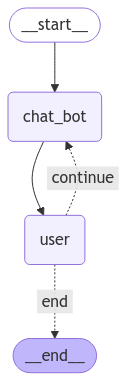

In [22]:
from IPython.display import Image, display

display(Image(simulation.get_graph().draw_mermaid_png()))

# Run Simulation

In [23]:
for chunk in simulation.stream({'messages': []}):
    # Print out all events aside from the final en chunk
    if END not in chunk:
        print(chunk)
        print('-----')

{'chat_bot': {'messages': [AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={}, id='02e3fce8-6f53-440b-bcb8-43f43bb27bed')]}}
-----
{'user': {'messages': [HumanMessage(content='Hello, I am Harrison. I am contacting you because I would like to request a refund for a trip I took to Alaska with your airline company five years ago. I am seeking a full refund for the trip. Can you please assist me with this request?', additional_kwargs={}, response_metadata={}, id='be42e40c-9932-451f-b799-f2ab101b572c')]}}
-----
{'chat_bot': {'messages': [AIMessage(content='Hello Harrison, thank you for reaching out. I will do my best to assist you with your refund request for your trip to Alaska five years ago. In order to process your request, could you please provide me with the following details:\n\n1. Your full name as it appears on the ticket\n2. The date of the trip to Alaska\n3. The booking reference number or ticket number, if you have it available\n\nOnce I 